In [69]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder,StandardScaler, scale
from sklearn.model_selection import train_test_split  # Libraries for ML
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import metrics,tree
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore') # We can suppress the warnings



In [70]:
df = pd.read_csv('Luas_Journey.csv')

# Please only two decimals in the output!!
# This line will give us just two decimals for every pd dataframe displayed
pd.set_option('display.float_format', lambda x: '%.2f' % x) 

df.head()

,Week,Luas_Line,VALUE,Year
0,2019 Week 01,Red line,274139.00,2019
1,2019 Week 01,Green line,275394.00,2019
2,2019 Week 02,Red line,408199.00,2019
3,2019 Week 02,Green line,430823.00,2019
4,2019 Week 03,Red line,376785.00,2019


In [71]:
df.shape

(504, 4)

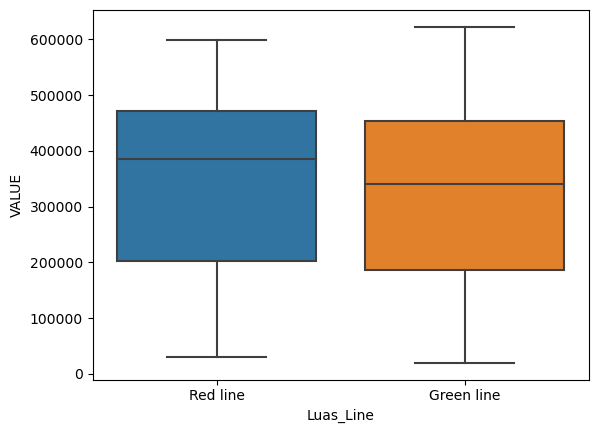

In [72]:
# Box plot to identify outliers
sns.boxplot(x='Luas_Line', y='VALUE', data=df)
plt.show()


In [73]:
from scipy import stats

# Calculate z-scores
z_scores = stats.zscore(df['VALUE'])

# Define a threshold for outliers, e.g., 3 standard deviations
threshold = 1
outliers = (z_scores > threshold) | (z_scores < -threshold)

# Print and visualize outliers
print("Indices of outliers:", df[outliers].index)


Indices of outliers: Index([ 24,  25,  42,  52,  53,  73,  74,  75,  76,  77,
       ...
       493, 494, 495, 496, 497, 498, 499, 500, 501, 502],
      dtype='int64', length=193)


In [74]:
# Remove outliers
df_no_outliers = df[~outliers]

# Check the shape of the new dataframe
print("Shape after removing outliers:", df_no_outliers.shape)


Shape after removing outliers: (311, 4)


In [79]:
# Move the 'Year' column to the second position
df_no_outliers.insert(2, 'Year', df_no_outliers.pop('Year'))

In [80]:
# Counting the values that each year has:
year_counts = df_no_outliers['Year'].value_counts().sort_index()
year_counts

Year
2019    72
2020    36
2021    62
2022    85
2023    56
Name: count, dtype: int64

In [81]:
# Creating variables for each year and storing the values to perform Confidence Intervals:

df_2019 = df[(df['Year'] == 2019)].copy()
df_2019.reset_index(drop=True, inplace=True)
df_2020 = df[(df['Year'] == 2020)].copy()
df_2020.reset_index(drop=True, inplace=True)
df_2021 = df[(df['Year'] == 2021)].copy()
df_2021.reset_index(drop=True, inplace=True)
df_2022 = df[(df['Year'] == 2022)].copy()
df_2022.reset_index(drop=True, inplace=True)

In [82]:
# Creating a LabelEncoder instance
le = LabelEncoder()

# Encoding the 'Sex' column
df_no_outliers['Luas_Line'] = le.fit_transform(df_no_outliers['Luas_Line'])

df_no_outliers

,Week,Luas_Line,Year,VALUE
0,2019 Week 01,1,2019,274139.00
1,2019 Week 01,0,2019,275394.00
2,2019 Week 02,1,2019,408199.00
3,2019 Week 02,0,2019,430823.00
4,2019 Week 03,1,2019,376785.00
...,...,...,...,...
486,2023 Week 36,1,2023,465836.00
487,2023 Week 36,0,2023,432905.00
488,2023 Week 37,1,2023,462007.00
489,2023 Week 37,0,2023,445474.00


Encoding target variable *"Luas_Line"*:<br>
*"Red Line"* = 0 <br>
*"Green Line"* = 1<br>
Defining X and y variables:

In [83]:
X = df.iloc[:, [2,3]].values # Dependent variables
y = df.iloc[:, 1].values # Target variable

In [84]:
X

array([[  2019., 274139.],
       [  2019., 275394.],
       [  2019., 408199.],
       ...,
       [  2023., 528068.],
       [  2023., 502054.],
       [  2023., 447017.]])

In [85]:
y

array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,

## Splitting the dataset into the Training set and Test set

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

## Feature Scaling

In [93]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# DecisionTreeClassifier
## Training the Decision Tree Classification model on the Training set

In [94]:
classifier = DecisionTreeClassifier(max_depth = 4, random_state = 42)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

## Predicting the Test and set results

In [95]:
y_pred = classifier.predict(X_test)

## Making the Confusion Matrix

              precision    recall  f1-score   support

           0       0.50      0.89      0.64        62
           1       0.56      0.14      0.23        64

    accuracy                           0.51       126
   macro avg       0.53      0.51      0.43       126
weighted avg       0.53      0.51      0.43       126

Classifier Accuracy: 50.79


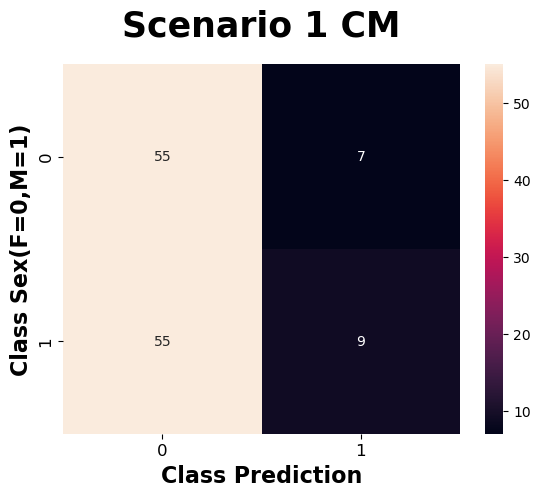

In [96]:
from sklearn.metrics import confusion_matrix # We need to reimport this libary, otherwise breaks

# Calculating confusion matrix

cm = confusion_matrix(y_test, y_pred)

# Call a method heatmap() to plot confusion matrix
sns.heatmap(cm, annot = True,fmt='d')
plt.title('Scenario 1 CM',loc="center", pad=20, fontsize=25, fontweight="bold")
plt.xlabel('Class Prediction',fontsize=16, fontweight='bold')
plt.ylabel('Class Sex(F=0,M=1)',fontsize=16, fontweight='bold')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# We don't want scientific notation
np.set_printoptions(suppress=True)

# print the classification_report based on y_test and y_predict
print(classification_report(y_test, y_pred))
# Which is the accuracy for the classifier???
print("Classifier Accuracy:",round(metrics.accuracy_score(y_test, y_pred),4)*100)

In [97]:
# instantiate the classifier 
rfc = RandomForestClassifier(random_state=0)

# fit the model
rfc.fit(X_train, y_train)

# Predict the Test set results
y_pred = rfc.predict(X_test)

print('Model accuracy score with 10 decision-trees : {0:0.2f}'. format(accuracy_score(y_test, y_pred)*100))

Model accuracy score with 10 decision-trees : 50.79
